# AGN Selection Through Artificial Intelligence¶

This notebook performs AGN Selection via an Autoencoder. The frameworks used for this deep learning model are TensorFlow and Pytorch.


## Authors

* Ash Karale
    

## Contents:

* [I. Introduction](#one)
* [II. MNIST Experiment](#two)
* [IIa. MNIST AGN Experiment](#three)
* [III. AGN DC Experiment](#four)
* [IIIa. Data Acquisition](#five)
* [IIIb. Exploratory Data Analysis](#six)
* [IIIc. Data Processing](#seven)
* [IV. Autoencoder Experiments](#eight)
* [IVa. Model Definition](#nine)
* [IVb. Model Visualization](#ten)
* [IVc. Model Training](#eleven)
* [IVd. Model Output](#twelve)


## Versions:

Initial Version: November 2022 (Ash Karale)

Latest Version: November 2023 (Ash Karale)



## I. Introduction <a class="anchor" id="one"></a>

With the upcoming Legacy Survey of Space and Time potentially identifying 40 billion celestial objects, our goal is to pinpoint the 100 million that are AGNs - a classic "needle-in-a- haystack" problem that requires sophisticated machine learning techniques to handle. We explore the use of autoencoders for AGN selection from data akin to the anticipated LSST survey. 

The data is gathered from the AGN Data Challenge which comprises of two primary sources known as the Sloan Digital Sky Survey Stripe 82, and the XMM-Large Scale Structure area. Furthermore, we explore the comparative effectiveness of TensorFlow and PyTorch in constructing autoencoders, providing an interface between computer science and astronomy.

### Visual Demonstration

Our primary goal is to gain a solid understanding of neural networks and a specialized type of them- autoencoders, so we can use them to do AGN science.

Neural networks are a cornerstone of artificial intelligence and machine learning. They draw inspiration from the human brain, using interconnected nodes or "neurons" to process information and make decisions. A neural network takes in inputs, which are processed in hidden layers using weights that are adjusted during training. The model then outputs a prediction. The weights are adjusted to find patterns in order to map inputs to outputs.
\
![Neural Networks](neural_networks.png)
\
One particular type of neural network that we will delve deeper into is an autoencoder. Autoencoders are unsupervised learning models that are used for data compression, noise reduction, and feature extraction. They have an interesting architecture, consisting of an encoder that compresses the input data and a decoder that attempts to reconstruct the original input</font> from the compressed data.
\
![Autoencoder](autoencoder.png)
\
We will be implementing a simple autoencoder using the popular deep learning library, Keras, and the well-known MNIST dataset.


## II. MNIST Experiment <a class="anchor" id="two"></a>

We will use the famous MNIST dataset for the purpose of demonstration. Note that this dataset is used because of its simplicity and ready availability, though the concepts can be applied to more complex datasets, including those related to active galaxies in astronomy.

In Python, we use the Keras API which works on top of TensorFlow to implement our autoencoder:

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import numpy as np

# Load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize all values between 0 and 1 for easier processing by the neural network.
# Neural networks often perform better on normalized data.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten the 28x28 images into vectors of size 784
# GTR: Why don't you just use the "flatten function"??
# Ash: The reshape function is indeed similar to flatten. Using flatten() is more
# explicit and could be clearer to new students. The following line is equivalent:
# x_train = x_train.reshape((len(x_train), -1))
# The -1 in reshape automatically calculates the size of the flattened dimension.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

The MNIST dataset contains 60,000 training images and 10,000 test images, each 28x28 pixels in size. By reshaping the data and normalizing pixel values to a [0,1] range, we prepare our input for the autoencoder. Although TensorFlow provides a flatten method, using reshape is a straightforward approach to convert the 2D image matrices into 1D vectors required for our dense neural network layers.

In [11]:
# Size of our encoded representations
# GTR: Should note that this is/was an arbitrary choice
# Ash: The encoding dimension is a hyperparameter that defines the size of the compressed
# representation. We chose 32 arbitrarily for this example, but in practice, we would
# experiment with different sizes to find the most effective encoding.
encoding_dim = 32  

# input placeholder
input_img = Input(shape=(784,))

# Adding a hidden layer before the bottleneck
hidden_layer = Dense(128, activation='relu')(input_img)

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# Adding a hidden layer after the bottleneck
hidden_layer_decoded = Dense(128, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

We choose an encoding dimension of 32 to compress the input; this is a balance between retaining enough information and achieving meaningful compression. ReLU is selected for the encoder to introduce non-linearity, helping the model learn complex patterns without the vanishing gradient problem. For the decoder, we use a sigmoid activation because we want the output values to be in the range [0,1], the same as our input data.
The addition of a 128-node hidden layer before and after the encoding layer introduces additional levels of abstraction, allowing the network to learn more complex representations. This also enhances the "funneling" effect, where data is compressed down to a lower-dimensional latent space and then expanded back to its original dimension. This structure encourages the autoencoder to learn a more robust representation of the input data.

In [12]:
# Compile the model
# GTR: briefly explain the choice of parameters here (and in the 5 lines of code above)
# Ash: Here we're setting up our model with the 'adam' optimizer which is a popular choice
# due to its efficiency. We're using 'binary_crossentropy' as our loss function since
# we're treating the reconstruction of each pixel as a binary classification problem
# (the output is between 0 and 1 due to the sigmoid activation).
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

The adam optimizer is used for its adaptive learning rate capabilities, which help converge to the optimal set of weights more efficiently. We employ binary cross-entropy as the loss function, which is suited for a reconstruction task where the output is a probability in the range [0,1], representing the likelihood of each pixel being active (or white in this case).

In [13]:
# Train autoencoder for 50 epochs
# GTR: briefly explain the choice of parameters here
# Ash: We are training our model for 50 iterations over the entire dataset (epochs),
# using a batch size of 256. 'Shuffle=True' shuffles the training data every epoch to prevent
# cyclic patterns that could affect learning. We're using the test data as validation data
# to monitor overfitting during training.
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
  1/235 [..............................] - ETA: 1:08 - loss: 0.6943

2023-11-27 13:03:12.104544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x256x1x784xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x256x1x784xi1

235/235 [==============================] - ETA: 0s - loss: 0.2775

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x96x1x784xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x96x1x784xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerforman

235/235 [==============================] - 2s 8ms/step - loss: 0.2775 - val_loss: 0.1903
Epoch 2/50
 28/235 [==>...........................] - ETA: 1s - loss: 0.1900

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x16x1x784xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x16x1x784xi1>'


235/235 [==============================] - 2s 6ms/step - loss: 0.1711 - val_loss: 0.1524
Epoch 3/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1429 - val_loss: 0.1326
Epoch 4/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1276 - val_loss: 0.1208
Epoch 5/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1180 - val_loss: 0.1128
Epoch 6/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1113 - val_loss: 0.1071
Epoch 7/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1062 - val_loss: 0.1028
Epoch 8/50
235/235 [==============================] - 1s 6ms/step - loss: 0.1026 - val_loss: 0.0999
Epoch 9/50
235/235 [==============================] - 2s 7ms/step - loss: 0.0998 - val_loss: 0.0976
Epoch 10/50
235/235 [==============================] - 2s 7ms/step - loss: 0.0979 - val_loss: 0.0959
Epoch 11/50
235/235 [==============================] - 2s 6ms/step - loss: 0.0965 - val_loss: 0.0947
Epoch 12/

The choice of 50 epochs is to give the model sufficient time to learn, as autoencoders typically require more epochs for training due to their complexity. A batch size of 256 is large enough for efficient processing and small enough to maintain a noisy gradient descent, which often helps in finding global minima. Shuffling the data ensures that each batch is different, which helps in preventing overfitting and makes the model more robust.

In [14]:
# Use the trained autoencoder to make predictions on the test data
# GTR: Be more specific.
# Ash: Here, we use the trained autoencoder to predict the test images. We input the flattened image arrays
# and the model outputs the reconstructed images. This is a process of encoding the original
# high-dimensional data into a lower-dimensional form and then decoding it back into the original space,
# inevitably losing some information but trying to minimize this loss.
decoded_imgs = autoencoder.predict(x_test)

 88/313 [=======>......................] - ETA: 0s

2023-11-27 13:04:28.379377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step


The predict function applies the trained autoencoder to the test data, encoding and then decoding it to produce a reconstruction. This serves as a test to see how well the autoencoder can generalize to new, unseen data, given that it has learned a compact representation of the training data.

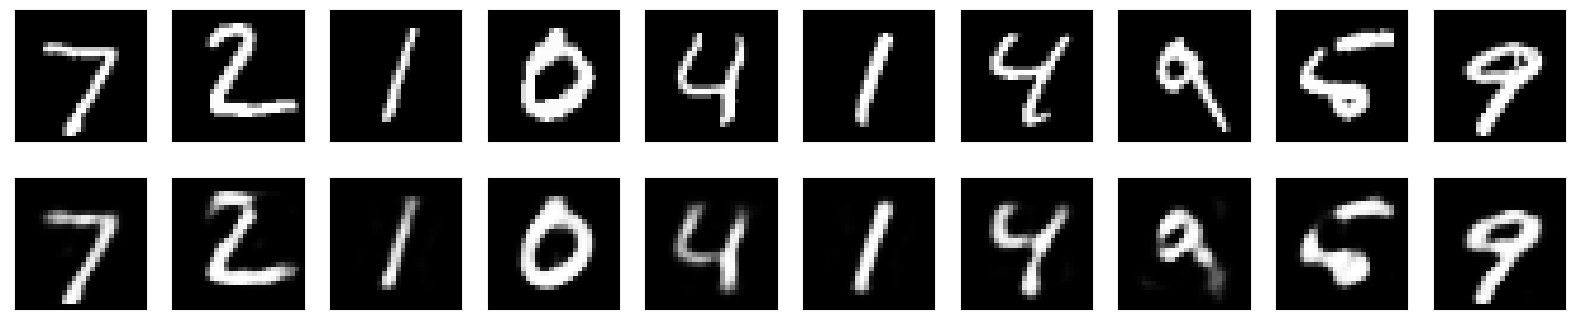

In [15]:
# Use Matplotlib to visualize the reconstructed inputs
import matplotlib.pyplot as plt

# GTR: Remind user how many there are in the dataset and that this is just a sample for visual checking that
# GTR: things are indeed working
# Ash: The test dataset contains 10,000 images, but we'll only visualize a subset of 10 to see
# the reconstruction quality. This provides a quick check to ensure that our autoencoder is
# learning to compress and reconstruct the images effectively.
n = 10  # Number of digits to display as a sample from the test set

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    # The subplot below will display the reconstructed image that corresponds to the original image above.
    # It is reshaped back to 28x28 pixels from the flattened output of the autoencoder.
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Finally, we visualize 10 examples to qualitatively evaluate the autoencoder's performance. It's important to remember that the MNIST test dataset contains 10,000 images. Here, we're only sampling a small subset for visualization to check if the autoencoder is reconstructing digits that visually resemble the originals, despite the dimensionality reduction and subsequent information loss.

This gives us a solid foundation to start understanding how neural networks and autoencoders function. We can apply this same basic concept to selecting AGNs from the AGN DC Dataset.

### Application to AGN DC Dataset: Understanding and Implementing Autoencoders

To understand how the process of using an autoencoder relates to our dataset—the AGN DC, which is the Sloan Digital Sky Survey (SDSS) Stripe 82, and the XMM-Large Scale Structure (XMM-LSS)—we need to consider the nature of the data and the benefits of the autoencoder model.

Our astronomical data sources provide us with a high-dimensional dataset. Each data point (e.g., an observed galaxy, star, or AGN) might come with several associated attributes such as its light curve features, astrometry, photometry, color, morphology, etc.

In this high-dimensional space, meaningful patterns or structures may not be immediately evident. Furthermore, as the data from these sources might not fully represent the diversity of astronomical objects that LSST will observe, direct application of supervised learning might lead to biased or incomplete models.

This is where autoencoders come into play. Autoencoders are a type of neural network that can learn to compress data into a lower-dimensional representation. In the encoding stage, the autoencoder learns to capture the most salient features of the data, effectively reducing its dimensionality. This process can help reveal underlying structure in the data that might be difficult to discern in the original high-dimensional space.

In the decoding stage, the autoencoder learns to reconstruct the original data from the compressed representation. By comparing the original data with the reconstructed data (as we do visually in the code block), we can get a sense of how well the autoencoder has learned to capture the essential features of the data.

The encoded representation, or the "latent space", holds a compressed form of the data that ideally captures its most important features. This latent space can then be used as input to a supervised classification algorithm, which can be more manageable and more effective than working with the original high-dimensional data.

So, in our case, the autoencoder serves two purposes:

i. It helps us explore and understand the structure of our high-dimensional astronomical data.

ii. It provides a form of unsupervised pre-training that can compensate for the underrepresentation in our training data. The autoencoder learns general features from the entire dataset, and this learning can then be fine-tuned with our specific but limited labeled data.

Thus, our visual comparison of original and autoencoder-reconstructed images (or data points) in the code block serves as an intuitive performance check for our model, indicating how well the autoencoder can capture the essential features of our complex astronomical dataset.

## IIa. MNIST AGN Experiment <a class="anchor" id="three"></a>

In the context of astronomy, each observation (or astronomical object) can be likened to an individual digit in the MNIST dataset, and each feature of this observation can be thought of as a pixel. However, unlike pixels in an image that combine to form a visual pattern, features in astronomical data do not inherently create a visual image but rather comprise a multi-dimensional feature space. Most astronomical data is non-image data, where each feature represents a different characteristic of the observation, such as luminosity, color index, or spectral line properties.

Given this, we will use the MNIST dataset as a stand-in for our astronomical data to demonstrate the process before applying it to actual astronomical datasets. In this educational example, we categorize '3s', '5s', and '7s' from MNIST as our three classes analogous to stars, quasars, and galaxies, respectively.

Our objective with the autoencoder isn't to reconstruct images but to learn a reduced representation of the data that can help in classifying these astronomical objects into one of the three categories. It's important to note that while an autoencoder is typically used for dimensionality reduction or feature learning, in a real-world scenario, we would likely use a classification algorithm directly, possibly leveraging the features learned by an autoencoder.

Here is how we might structure our experimental approach:

Generate Synthetic Astronomical Data:
Instead of image data, create a dataset where each entry represents an astronomical object with features corresponding to different observations.
Normalize this data so that each feature has a similar range, important for training neural networks effectively.

1. Define the Autoencoder:
Use the same architecture as before but ensure it is suitable for the dimensionality of our synthetic data.
Keep in mind that we may need to adjust the size and number of layers depending on the complexity and size of the actual data.

2. Training:
Train the autoencoder on this synthetic dataset to learn the essential features.
While training on MNIST, we are implicitly assuming that each class ('3', '5', '7') is sufficiently distinct in its feature space, analogous to stars, quasars, and galaxies.

3. Reconstruction and Visualization:
After training, we use the autoencoder to reconstruct the data points for each class.
We then visualize the original and reconstructed data using histograms or similar statistical tools to assess the performance. The x-axis of these histograms would represent the feature values, and the y-axis would represent their frequency or distribution.

4. Multiclass Classification:
Ultimately, the goal is to label each astronomical object with its respective class and provide probabilities for each class.
This step might require additional classification layers or algorithms beyond the autoencoder.

By first working with the MNIST dataset, we can understand the autoencoder's mechanics in a controlled environment before moving to real astronomical data, which may be more complex and less structured.

In [16]:
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np
from keras.datasets import mnist

# Assume we have three classes and create a list of class names
class_names = ['star', 'quasar', 'galaxy']

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Filter data for only "3", "5", "7" digits and normalize, flatten
# GTR: Need more comments about this (either here or in markdown cells)
# Ash: Filtering MNIST data to only use 3s, 5s, and 7s to represent stars, quasars, and galaxies respectively. 
# Each image is flattened from a 28x28 matrix to a 784-element vector and then normalized so each pixel value is between 0 and 1.
star_data = x_train[y_train == 3].reshape(-1, 784).astype('float32') / 255
quasar_data = x_train[y_train == 5].reshape(-1, 784).astype('float32') / 255
galaxy_data = x_train[y_train == 7].reshape(-1, 784).astype('float32') / 255

# Concatenate all data into a single array
# GTR: Say something about this repackaging all three data types into one data set 
# (where we wouldn't necessarily know the class).  Might be good to force some class imbalance here.
# GTR: Or do it balanced first, then unbalanced to see what difference that makes and talk about solutions.
# Ash: Combining star, quasar, and galaxy data into one dataset to simulate a mixed, unlabeled astronomical dataset.
all_data = np.concatenate([star_data, quasar_data, galaxy_data])

# Normalizing the data by a MinMaxScaler and fit the scaler to the data and transform it
# GTR: Worth noting here that applying such a scalar might not make sense for real astro data.
# GTR: Or at least not for all the features. E.g., some features are log quantities, some are negative, etc.
# Ash: Normalizing the concatenated data, though real astronomical data may require different preprocessing.
scaler = MinMaxScaler()
all_data = scaler.fit_transform(all_data)

# Apply PCA for dimensionality reduction
# GTR: Note that we are doing this mostly for visualization purposes. So that we can plot the input and output data.
# GTR: Otherwise, we have to check 784 features. (Although, I suppose that we could just spot check 10 of them.)
# Ash: Reducing dimensionality to 10 principal components for simplifying visualization and interpretation.
pca = PCA(n_components=10)
all_data_reduced = pca.fit_transform(all_data)

# Define autoencoder architecture
# Define input layer, adjust the input dimension to match the PCA-reduced data
input_layer = Input(shape=(all_data_reduced.shape[1],))
# Define the encoding layers with linear activation
encoded = Dense(128, activation='linear')(input_layer)
encoded = Dense(64, activation='linear')(encoded)
encoded = Dense(32, activation='linear')(encoded)

# Define the decoding layers with linear activation
decoded = Dense(64, activation='linear')(encoded)
decoded = Dense(128, activation='linear')(decoded)
decoded = Dense(all_data_reduced.shape[1], activation='linear')(decoded)  # Match output dimension to input

# Instantiate and compile the autoencoder model
# GTR: As above. Why linear? Why mse? Etc.
# Ash: Using linear activation functions and MSE loss as this is a simple example focusing on reconstructing input values.
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Fit the model to the PCA-reduced data
autoencoder.fit(all_data_reduced, all_data_reduced,
                epochs=200,
                batch_size=256,
                shuffle=True)

# Generate reconstructions of the input data
decoded_data = autoencoder.predict(all_data_reduced)

# Following the reconstruction, we would compare the original and decoded datasets to evaluate the autoencoder's performance.

Epoch 1/200
 1/70 [..............................] - ETA: 25s - loss: 3.3803

2023-11-27 13:04:33.749536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 1s 8ms/step - loss: 0.2793
Epoch 2/200
70/70 [==============================] - 0s 6ms/step - loss: 1.0819e-04
Epoch 3/200
70/70 [==============================] - 0s 7ms/step - loss: 9.5586e-08
Epoch 4/200
70/70 [==============================] - 0s 7ms/step - loss: 8.7526e-11
Epoch 5/200
70/70 [==============================] - 0s 7ms/step - loss: 1.6935e-13
Epoch 6/200
70/70 [==============================] - 0s 7ms/step - loss: 1.1424e-13
Epoch 7/200
70/70 [==============================] - 0s 7ms/step - loss: 1.1449e-13
Epoch 8/200
70/70 [==============================] - 0s 6ms/step - loss: 1.1470e-13
Epoch 9/200
70/70 [==============================] - 0s 7ms/step - loss: 1.1512e-13
Epoch 10/200
70/70 [==============================] - 0s 7ms/step - loss: 1.1507e-13
Epoch 11/200
70/70 [==============================] - 0s 7ms/step - loss: 1.1550e-13
Epoch 12/200
70/70 [==============================] - 0s 7ms/step - loss: 1.1537e-13
Epoch

70/70 [==============================] - 0s 6ms/step - loss: 7.4073e-05
Epoch 193/200
70/70 [==============================] - 0s 6ms/step - loss: 2.1360e-05
Epoch 194/200
70/70 [==============================] - 0s 6ms/step - loss: 9.6516e-06
Epoch 195/200
70/70 [==============================] - 0s 6ms/step - loss: 1.1060e-05
Epoch 196/200
70/70 [==============================] - 0s 6ms/step - loss: 9.2500e-05
Epoch 197/200
70/70 [==============================] - 0s 6ms/step - loss: 1.5159e-04
Epoch 198/200
70/70 [==============================] - 0s 6ms/step - loss: 2.3784e-04
Epoch 199/200
70/70 [==============================] - 0s 6ms/step - loss: 1.5659e-04
Epoch 200/200
 79/557 [===>..........................] - ETA: 0s

2023-11-27 13:06:05.840401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


557/557 [==============================] - 1s 2ms/step


In the following cells, we will visualize the reconstruction quality of the autoencoder. We start by examining the first principal component for its distinctiveness across our classes.

NameError: name 'original_data_lengths' is not defined

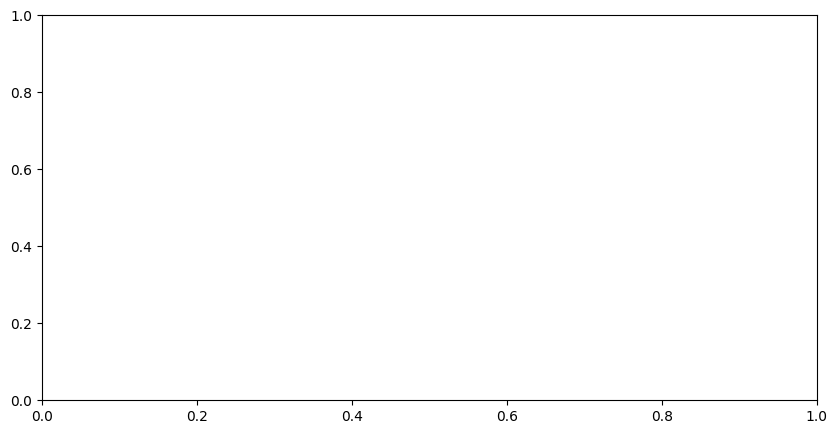

In [17]:
import matplotlib.pyplot as plt

# First, plot for Eigenvector 1 to assess its distinctiveness across classes
fig, ax = plt.subplots(figsize=(10, 5))  # Single plot for eigenvector 1
eigenvector_index = 0  # Index for the first eigenvector

# Loop over each class for eigenvector 1
for j, class_name in enumerate(class_names):
    # Extract original and decoded data for the first eigenvector for current class
    original_data_j = all_data_reduced[:, eigenvector_index][original_data_lengths[j]*j:original_data_lengths[j]*(j+1)]
    decoded_data_j = decoded_data_pca[:, eigenvector_index][original_data_lengths[j]*j:original_data_lengths[j]*(j+1)]
    
    # Plot original data for eigenvector 1
    ax.hist(original_data_j, bins=50, color=colors_original[j], edgecolor='black', alpha=0.7, label=f'{class_name} Original')
    
    # Plot decoded data for eigenvector 1
    ax.hist(decoded_data_j, bins=50, color=colors_decoded[j], edgecolor='black', alpha=0.5, linestyle='dashed', label=f'{class_name} Decoded')

# Set title and labels, and add a legend for eigenvector 1
ax.set_title(f'Eigenvector {eigenvector_index+1}')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.legend()

# Show the plot for eigenvector 1
plt.tight_layout()
plt.show()

Next, we will examine selected eigenvectors (2, 5, 8, and 9) where one class is expected to separate well from the others. Following this, we will look at the remaining eigenvectors to analyze class overlap.

In [ ]:
# Plot for selected eigenvectors with potentially good class separation
well_separated_eigenvectors = [1, 4, 7, 8]  # considering 0-indexing, these correspond to eigenvectors 2, 5, 8, and 9
fig, axes = plt.subplots(len(well_separated_eigenvectors), 1, figsize=(10, 5 * len(well_separated_eigenvectors)))

# Loop over each selected eigenvector
for idx, eigenvector_index in enumerate(well_separated_eigenvectors):
    for j, class_name in enumerate(class_names):
        # Extract original and decoded data for current eigenvector and class
        original_data_j = all_data_reduced[:, eigenvector_index][original_data_lengths[j]*j:original_data_lengths[j]*(j+1)]
        decoded_data_j = decoded_data_pca[:, eigenvector_index][original_data_lengths[j]*j:original_data_lengths[j]*(j+1)]

        # Plot original data
        axes[idx].hist(original_data_j, bins=50, color=colors_original[j], edgecolor='black', alpha=0.7, label=f'{class_name} Original')
        
        # Plot decoded data
        axes[idx].hist(decoded_data_j, bins=50, color=colors_decoded[j], edgecolor='black', alpha=0.5, linestyle='dashed', label=f'{class_name} Decoded')

    # Set title and labels, and add a legend for each eigenvector
    axes[idx].set_title(f'Eigenvector {eigenvector_index+1}')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

# Show the plot for selected eigenvectors
plt.tight_layout()
plt.show()

In [ ]:
# Plot for the remaining eigenvectors with less class separation
other_eigenvectors = [i for i in range(10) if i not in well_separated_eigenvectors]
fig, axes = plt.subplots(len(other_eigenvectors), 1, figsize=(10, 5 * len(other_eigenvectors)))

for idx, eigenvector_index in enumerate(other_eigenvectors):
    for j, class_name in enumerate(class_names):
        original_data_j = all_data_reduced[:, eigenvector_index][original_data_lengths[j]*j:original_data_lengths[j]*(j+1)]
        decoded_data_j = decoded_data_pca[:, eigenvector_index][original_data_lengths[j]*j:original_data_lengths[j]*(j+1)]

        axes[idx].hist(original_data_j, bins=50, color=colors_original[j], edgecolor='black', alpha=0.7, label=f'{class_name} Original')
        axes[idx].hist(decoded_data_j, bins=50, color=colors_decoded[j], edgecolor='black', alpha=0.5, linestyle='dashed', label=f'{class_name} Decoded')

    axes[idx].set_title(f'Eigenvector {eigenvector_index+1}')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

plt.tight_layout()
plt.show()

We have explored the reconstruction quality of the autoencoder using PCA-reduced data across different principal components. This approach provided insight into the distinctiveness and overlap of classes within a reduced feature space, which is valuable for understanding the potential performance of classification models trained on this data.

## III. AGN DC Experiment <a class="anchor" id="four"></a>

### We Now Begin Exploring the AGN DC:

### Importing Modules

It is widely recommended to include the import statements for all the necessary modules at the beginning of a Jupyter Notebook or any Python program. 
This practice ensures that the required dependencies are properly imported and accessible at the required points in the code, thus avoiding any potential issues or errors related to missing modules or dependencies.

In [ ]:
# Importing all required modules

# System modules allow Python programs to interact with the operating system and perform tasks 
# such as reading and writing files, managing processes, and accessing environment variables 
import os
import sys
import importlib
import pickle
import argparse
import itertools
import csv
from tqdm import tqdm
import time

# Data manipulation modules allow users to perform various operations on data,
# such as cleaning, transforming, aggregating, filtering, and visualizing data
import math
import numpy as np
import pandas as pd

# Visualization modules allow users to create visual representations of data
import matplotlib as mpl
import matplotlib.pyplot as plt
import palettable
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file, show
# pd.set_option('display.max_columns', 1000)

# Scikit-learn provides a range of supervised and unsupervised learning algorithms,
# as well as tools for model selection and data preprocessing
from sklearn import model_selection, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, normalized_mutual_info_score, adjusted_rand_score

# Scipy is a Python library for scientific computing and technical computing
from scipy import stats
from scipy.optimize import linear_sum_assignment as linear_assignment

# Astropy is a Python library for astronomy and astrophysics
from astropy.io import fits
from astropy.table import Table

# TensorFlow is an open-source machine learning library that provides an extensive set of tools and libraries
# for building,training, and deploying neural networks, as well as other machine learning algorithms
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, regularizers, callbacks

# PyTorch is an open-source machine learning library for Python that provides a range of tools
# and functions for building and training neural networks and other machine learning models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,TensorDataset
from torch.autograd import Variable

print(sys.version)

## IIIa. Data Acquisition <a class="anchor" id="five"></a>

Data acquisition involves the collection and aggregation of data from diverse sources. This crucial initial stage in the data analysis pipeline entails recognizing data sources and acquiring the data in a format suitable for further analysis.

The provided statement establishes the data pathway. If an alternative data source is required, the line in the subsequent cell should be substituted accordingly.

In [ ]:
# Defining a variable named 'data_dir' and assigning it the string value /Users/ash/Research/Data/AGN_DataChallenge/ 
# This is the path to the directory where the dataset is stored on the local machine
data_dir = '/Users/ash/Research/Data/AGN_DataChallenge/ObjectTable.parquet'

# Using the display() function to display the value of the 'data_dir' variable in the output of the Jupyter Notebook
display(data_dir)

#### Data types

The measurements can be classified into several key categories:
- __Astrometry__ includes measurements of celestial coordinates such as right ascension (RA), declination (Dec), proper motion, and parallax.
- __Photometry__ encompasses both point and extended source photometry, providing measurements in terms of AB magnitudes and fluxes (expressed in nJy).
- __Color__ is determined by computing the ratios of fluxes in different wavelength bands.
- __Morphology__ is indicated by a binary value, with 1 representing extended sources and 0 representing point-like sources.
- __Light Curve Features__ are extracted from the SDSS light curves when a match is found.
- __Redshift__ is provided whenever available, including both spectroscopic and photometric measurements.

Inspecting the attributes

In [ ]:
object_df = pd.read_parquet(data_dir)
display(object_df.describe())
display(object_df.shape)

# Number of objects in each class + unlabeled
display(object_df['class'].value_counts())
display("Number of unlabeled objects: {}".format(object_df['class'].isna().sum()))

Stripe 82 is a region of the sky that has been observed multiple times by the Sloan Digital Sky Survey (SDSS). It is located along the celestial equator and covers about 300 square degrees. Because Stripe 82 has been observed so many times, it has very deep imaging, which means it can detect fainter objects than a typical SDSS image.

XMM-LSS stands for XMM-Large Scale Structure. It's an X-ray survey of the sky conducted by the XMM-Newton space telescope. It covers a region of about 11.1 square degrees and is designed to study large-scale cosmic structures like galaxy clusters and cosmic filaments.

The merging of these datasets likely aims to provide a more comprehensive view of the studied celestial objects, combining data from both optical (Stripe 82) and X-ray (XMM-LSS) observations.

#### Data Munging

#### Transforming Class Labels to Numerical Values

For computational efficiency and to facilitate the use of algorithms that require numerical input, we convert the original class labels into numerical values. We assign:

- `0` to `Star`
- `1` to `Gal`
- `2` to `Qso`, `Agn`, and `highZQso`

This transformation also merges `Agn` and `highZQso` into the `Qso` class. This is done to simplify our classification problem into three distinct categories, which are now represented by the numbers 0, 1, and 2, respectively. The following code cell executes this transformation and provides a summary of the distribution of the transformed class labels.


In [ ]:
# Replace original class labels with numerical values for easier processing
# 'Star' is assigned 0, 'Gal' is assigned 1, and 'Qso', 'Agn', 'highZQso' are assigned 2
# Effectively, 'Agn' and 'highZQso' are merged into 'Qso' class
## GTR: Better to explain in an markdown cell?
# Ash: Explained the label encoding process and the merging of classes in the markdown cell above.

object_df_new = object_df.replace({'class': {'Star': 0, 'Gal': 1, 'Qso': 2, 'Agn': 2, 'highZQso': 2}})

# Display the shape of 'class' column in the new dataframe to see total instances
# The shape will give us the total number of instances including labeled and unlabeled ones.
display(object_df_new['class'].shape)

# Count and display number of instances for each class (0, 1, 2)
# This will help us understand the distribution of our labeled instances.
display(object_df_new['class'].value_counts())

# Calculate and display the number of instances in 'class' column with no label (NaN values)
# This confirms the total number of unlabeled objects which may need further handling.
display("Number of unlabeled objects: {}".format(object_df_new['class'].isna().sum()))

## IIIb. Exploratory Data Analysis <a class="anchor" id="six"></a>

Our goal is to be able to distinguish one type of astronomical source from another. Specifically, AGNs and quasars from stars (of various temperatures), normal (inactive) galaxies, exploding stars, etc. These different objects emit different amounts of light at the different wavelengths.

We split the wavelength region into multiple bands, specifically for our dataset, the main source being SDSS- it is 5 bands: ugriz

The relevant features in our dataset fluxes in each of the ugriz bandpasses: psFlux

In [ ]:
attr_list = [
    # Point source parallax and proper motion
    'psParallax', 'psPm_ra', 'psPm_dec',

    # Point source flux in different bands
    'psFlux_u', 'psFlux_g', 'psFlux_r', 'psFlux_i', 'psFlux_z', 'psFlux_y',

    # Point source flux errors in different bands
    'psFluxErr_u', 'psFluxErr_g', 'psFluxErr_r', 'psFluxErr_i', 'psFluxErr_z', 'psFluxErr_y',

    # Bright disk flux in different bands
    'bdFlux_u', 'bdFlux_g', 'bdFlux_r', 'bdFlux_i', 'bdFlux_z', 'bdFlux_y',

    # Bright disk flux errors in different bands
    'bdFluxErr_u', 'bdFluxErr_g', 'bdFluxErr_r', 'bdFluxErr_i', 'bdFluxErr_z', 'bdFluxErr_y',

    # Point source magnitude in different bands
    'psMag_u', 'psMag_g', 'psMag_r', 'psMag_i', 'psMag_z', 'psMag_y',

    # Point source magnitude errors in different bands
    'psMagErr_u', 'psMagErr_g', 'psMagErr_r', 'psMagErr_i', 'psMagErr_z', 'psMagErr_y',

    # Bright disk magnitude in different bands
    'bdMag_u', 'bdMag_g', 'bdMag_r', 'bdMag_i', 'bdMag_z', 'bdMag_y',

    # Bright disk magnitude errors in different bands
    'bdMagErr_u', 'bdMagErr_g', 'bdMagErr_r', 'bdMagErr_i', 'bdMagErr_z', 'bdMagErr_y',

    # Extendedness in different bands
    'extendedness_u', 'extendedness_g', 'extendedness_r', 'extendedness_i', 'extendedness_z', 'extendedness_y',

    # Standard colors and their errors
    'stdColor_0', 'stdColor_1', 'stdColor_2', 'stdColor_3', 'stdColor_4', 
    'stdColorErr_0', 'stdColorErr_1', 'stdColorErr_2', 'stdColorErr_3', 'stdColorErr_4',

    # Class, estimated photometric redshift, true redshift, and flags in different bands
    'class', 'photoZ_pest', 'z','ebv', 'flags_u', 'flags_g', 'flags_r', 'flags_i', 'flags_z', 'flags_y',

    # Spectroscopic identifiers
    'spec_fiberid', 'spec_plate', 'spec_mjd',

    # Light curve periodic features in different bands for different periodic indices
    'lcPeriodic[0]_g',
    'lcPeriodic[0]_r', 'lcPeriodic[0]_i', 'lcPeriodic[1]_g', 'lcPeriodic[1]_r', 'lcPeriodic[1]_i', 
    'lcPeriodic[2]_g','lcPeriodic[2]_r', 'lcPeriodic[2]_i', 'lcPeriodic[3]_g', 'lcPeriodic[3]_r', 
    'lcPeriodic[3]_i', 'lcPeriodic[4]_u','lcPeriodic[4]_g', 'lcPeriodic[4]_r', 'lcPeriodic[4]_i', 
    'lcPeriodic[4]_z', 'lcPeriodic[5]_u', 'lcPeriodic[5]_g','lcPeriodic[5]_r', 'lcPeriodic[5]_i', 
    'lcPeriodic[5]_z', 'lcPeriodic[6]_u', 'lcPeriodic[6]_g', 'lcPeriodic[6]_r','lcPeriodic[6]_i', 
    'lcPeriodic[6]_z', 'lcPeriodic[7]_u', 'lcPeriodic[7]_g', 'lcPeriodic[7]_r', 'lcPeriodic[7]_i',
    'lcPeriodic[7]_z', 'lcPeriodic[8]_u', 'lcPeriodic[8]_g', 'lcPeriodic[8]_r', 'lcPeriodic[8]_i',
    'lcPeriodic[8]_z','lcPeriodic[9]_u', 'lcPeriodic[9]_g', 'lcPeriodic[9]_r', 'lcPeriodic[9]_i', 
    'lcPeriodic[9]_z', 'lcPeriodic[10]_u','lcPeriodic[10]_g', 'lcPeriodic[10]_r', 'lcPeriodic[10]_i', 
    'lcPeriodic[10]_z', 'lcPeriodic[11]_u',  'lcPeriodic[11]_g', 'lcPeriodic[11]_r', 'lcPeriodic[11]_i', 
    'lcPeriodic[11]_z', 'lcPeriodic[12]_u', 'lcPeriodic[12]_g', 'lcPeriodic[12]_r', 'lcPeriodic[12]_i', 
    'lcPeriodic[12]_z', 'lcPeriodic[13]_u',  'lcPeriodic[13]_g', 'lcPeriodic[13]_r', 'lcPeriodic[13]_i', 
    'lcPeriodic[13]_z', 'lcPeriodic[14]_u', 'lcPeriodic[14]_g', 'lcPeriodic[14]_r', 'lcPeriodic[14]_i', 
    'lcPeriodic[14]_z', 'lcPeriodic[15]_u', 'lcPeriodic[15]_g', 'lcPeriodic[15]_r', 'lcPeriodic[15]_i', 
    'lcPeriodic[15]_z', 'lcPeriodic[16]_u',  'lcPeriodic[16]_g', 'lcPeriodic[16]_r', 'lcPeriodic[16]_i', 
    'lcPeriodic[16]_z', 'lcPeriodic[17]_u','lcPeriodic[17]_g', 'lcPeriodic[17]_r', 'lcPeriodic[17]_i', 
    'lcPeriodic[17]_z', 'lcPeriodic[18]_u','lcPeriodic[18]_g', 'lcPeriodic[18]_r', 'lcPeriodic[18]_i', 
    'lcPeriodic[18]_z', 'lcPeriodic[19]_u','lcPeriodic[19]_g', 'lcPeriodic[19]_r', 'lcPeriodic[19]_i', 
    'lcPeriodic[19]_z', 'lcPeriodic[20]_u','lcPeriodic[20]_g', 'lcPeriodic[20]_r', 'lcPeriodic[20]_i', 
    'lcPeriodic[20]_z', 'lcPeriodic[21]_u', 'lcPeriodic[21]_g', 'lcPeriodic[21]_r', 'lcPeriodic[21]_i', 
    'lcPeriodic[21]_z', 'lcPeriodic[22]_u', 'lcPeriodic[22]_g', 'lcPeriodic[22]_r', 'lcPeriodic[22]_i', 
    'lcPeriodic[22]_z', 'lcPeriodic[23]_u', 'lcPeriodic[23]_g', 'lcPeriodic[23]_r', 'lcPeriodic[23]_i', 
    'lcPeriodic[23]_z', 'lcPeriodic[24]_u', 'lcPeriodic[24]_g', 'lcPeriodic[24]_r', 'lcPeriodic[24]_i', 
    'lcPeriodic[24]_z', 'lcPeriodic[25]_u',  'lcPeriodic[25]_g', 'lcPeriodic[25]_r', 'lcPeriodic[25]_i',
    'lcPeriodic[25]_z', 'lcPeriodic[26]_u',  'lcPeriodic[26]_g', 'lcPeriodic[26]_r', 'lcPeriodic[26]_i', 
    'lcPeriodic[26]_z', 'lcPeriodic[27]_u',  'lcPeriodic[27]_g', 'lcPeriodic[27]_r', 'lcPeriodic[27]_i',
    'lcPeriodic[27]_z', 'lcPeriodic[28]_u', 'lcPeriodic[28]_g', 'lcPeriodic[28]_r', 'lcPeriodic[28]_i', 
    'lcPeriodic[28]_z', 'lcPeriodic[29]_u', 'lcPeriodic[29]_g', 'lcPeriodic[29]_r', 'lcPeriodic[29]_i', 
    'lcPeriodic[29]_z', 'lcPeriodic[30]_u', 'lcPeriodic[30]_g', 'lcPeriodic[30]_r', 'lcPeriodic[30]_i', 
    'lcPeriodic[30]_z', 'lcPeriodic[31]_u',  'lcPeriodic[31]_g', 'lcPeriodic[31]_r', 'lcPeriodic[31]_i',
    'lcPeriodic[31]_z', 'lcPeriodic[32]_u', 'lcPeriodic[32]_g', 'lcPeriodic[32]_r', 'lcPeriodic[32]_i',
    'lcPeriodic[32]_z',

    # Light curve non-periodic features in different bands for different non-periodic indices
    'lcNonPeriodic[0]_u',
    'lcNonPeriodic[0]_g', 'lcNonPeriodic[0]_r', 'lcNonPeriodic[0]_i', 'lcNonPeriodic[0]_z', 'lcNonPeriodic[1]_u',
    'lcNonPeriodic[1]_g', 'lcNonPeriodic[1]_r', 'lcNonPeriodic[1]_i', 'lcNonPeriodic[1]_z', 'lcNonPeriodic[2]_u',
    'lcNonPeriodic[2]_g', 'lcNonPeriodic[2]_r', 'lcNonPeriodic[2]_i', 'lcNonPeriodic[2]_z', 'lcNonPeriodic[3]_u',
    'lcNonPeriodic[3]_g', 'lcNonPeriodic[3]_r', 'lcNonPeriodic[3]_i', 'lcNonPeriodic[3]_z', 'lcNonPeriodic[4]_u',
    'lcNonPeriodic[4]_g', 'lcNonPeriodic[4]_r', 'lcNonPeriodic[4]_i', 'lcNonPeriodic[4]_z', 'lcNonPeriodic[5]_u',
    'lcNonPeriodic[5]_g', 'lcNonPeriodic[5]_r', 'lcNonPeriodic[5]_i', 'lcNonPeriodic[5]_z', 'lcNonPeriodic[6]_u',
    'lcNonPeriodic[6]_g', 'lcNonPeriodic[6]_r', 'lcNonPeriodic[6]_i', 'lcNonPeriodic[6]_z', 'lcNonPeriodic[7]_u', 
    'lcNonPeriodic[7]_g', 'lcNonPeriodic[7]_r', 'lcNonPeriodic[7]_i', 'lcNonPeriodic[7]_z', 'lcNonPeriodic[8]_u',
    'lcNonPeriodic[8]_g', 'lcNonPeriodic[8]_r', 'lcNonPeriodic[8]_i', 'lcNonPeriodic[8]_z', 'lcNonPeriodic[9]_u',
    'lcNonPeriodic[9]_g', 'lcNonPeriodic[9]_r', 'lcNonPeriodic[9]_i', 'lcNonPeriodic[9]_z', 'lcNonPeriodic[10]_u',
    'lcNonPeriodic[10]_g', 'lcNonPeriodic[10]_r', 'lcNonPeriodic[10]_i', 'lcNonPeriodic[10]_z',
    'lcNonPeriodic[11]_u', 'lcNonPeriodic[11]_g', 'lcNonPeriodic[11]_r', 'lcNonPeriodic[11]_i',
    'lcNonPeriodic[11]_z', 'lcNonPeriodic[12]_u', 'lcNonPeriodic[12]_g', 'lcNonPeriodic[12]_r', 
    'lcNonPeriodic[12]_i', 'lcNonPeriodic[12]_z', 'lcNonPeriodic[13]_u', 'lcNonPeriodic[13]_g',
    'lcNonPeriodic[13]_r', 'lcNonPeriodic[13]_i', 'lcNonPeriodic[13]_z', 'lcNonPeriodic[14]_u', 
    'lcNonPeriodic[14]_g', 'lcNonPeriodic[14]_r', 'lcNonPeriodic[14]_i', 'lcNonPeriodic[14]_z', 
    'lcNonPeriodic[15]_u', 'lcNonPeriodic[15]_g', 'lcNonPeriodic[15]_r', 'lcNonPeriodic[15]_i', 
    'lcNonPeriodic[15]_z', 'lcNonPeriodic[16]_u', 'lcNonPeriodic[16]_g', 'lcNonPeriodic[16]_r', 
    'lcNonPeriodic[16]_i', 'lcNonPeriodic[16]_z', 'lcNonPeriodic[17]_u', 'lcNonPeriodic[17]_g', 
    'lcNonPeriodic[17]_r', 'lcNonPeriodic[17]_i', 'lcNonPeriodic[17]_z', 'lcNonPeriodic[18]_u',
    'lcNonPeriodic[18]_g', 'lcNonPeriodic[18]_r', 'lcNonPeriodic[18]_i', 'lcNonPeriodic[18]_z',
    'lcNonPeriodic[19]_u', 'lcNonPeriodic[19]_g', 'lcNonPeriodic[19]_r', 'lcNonPeriodic[19]_i', 
    'lcNonPeriodic[19]_z', 'lcNonPeriodic[20]_u', 'lcNonPeriodic[20]_g', 'lcNonPeriodic[20]_r', 
    'lcNonPeriodic[20]_i', 'lcNonPeriodic[20]_z', 'lcNonPeriodic[21]_u', 'lcNonPeriodic[21]_g',
    'lcNonPeriodic[21]_r', 'lcNonPeriodic[21]_i', 'lcNonPeriodic[21]_z', 'lcNonPeriodic[22]_u', 
    'lcNonPeriodic[22]_g', 'lcNonPeriodic[22]_r', 'lcNonPeriodic[22]_i', 'lcNonPeriodic[22]_z', 
    'lcNonPeriodic[23]_u', 'lcNonPeriodic[23]_g', 'lcNonPeriodic[23]_r', 'lcNonPeriodic[23]_i', 
    'lcNonPeriodic[23]_z', 'lcNonPeriodic[24]_u', 'lcNonPeriodic[24]_g', 'lcNonPeriodic[24]_r',
    'lcNonPeriodic[24]_i', 'lcNonPeriodic[24]_z', 'lcNonPeriodic[25]_u', 'lcNonPeriodic[25]_g', 
    'lcNonPeriodic[25]_r', 'lcNonPeriodic[25]_i', 'lcNonPeriodic[25]_z', 'lcNonPeriodic[26]_u',
    'lcNonPeriodic[26]_g', 'lcNonPeriodic[26]_r', 'lcNonPeriodic[26]_i', 'lcNonPeriodic[26]_z', 
    'lcNonPeriodic[27]_u', 'lcNonPeriodic[27]_g', 'lcNonPeriodic[27]_r', 'lcNonPeriodic[27]_i', 
    'lcNonPeriodic[27]_z', 'lcNonPeriodic[28]_u', 'lcNonPeriodic[28]_g', 'lcNonPeriodic[28]_r',
    'lcNonPeriodic[28]_i','lcNonPeriodic[28]_z'
            ]

In [ ]:
attr_noerror = [
    # Point source parallax and proper motion
    'psParallax', 'psPm_ra', 'psPm_dec',

    # Point source flux in different bands
    'psFlux_u', 'psFlux_g', 'psFlux_r', 'psFlux_i', 'psFlux_z', 'psFlux_y',

    # Bright disk flux in different bands
    'bdFlux_u', 'bdFlux_g', 'bdFlux_r', 'bdFlux_i', 'bdFlux_z', 'bdFlux_y',

    # Point source magnitude in different bands
    'psMag_u', 'psMag_g', 'psMag_r', 'psMag_i', 'psMag_z', 'psMag_y',

    # Bright disk magnitude in different bands
    'bdMag_u', 'bdMag_g', 'bdMag_r', 'bdMag_i', 'bdMag_z', 'bdMag_y',

    # Extendedness in different bands
    'extendedness_u', 'extendedness_g', 'extendedness_r', 'extendedness_i', 'extendedness_z', 'extendedness_y',

    # Standard colors
    'stdColor_0', 'stdColor_1', 'stdColor_2', 'stdColor_3', 'stdColor_4',

    # Class, estimated photometric redshift, true redshift, and flags in different bands
    'class', 'photoZ_pest', 'z','ebv', 'flags_u', 'flags_g', 'flags_r', 'flags_i', 'flags_z', 'flags_y',

    # Spectroscopic identifiers
    'spec_fiberid', 'spec_plate', 'spec_mjd',

    # Light curve periodic features in different bands for different periodic indices
    'lcPeriodic[0]_g',
    'lcPeriodic[0]_r', 'lcPeriodic[0]_i', 'lcPeriodic[1]_g', 'lcPeriodic[1]_r', 'lcPeriodic[1]_i', 
    'lcPeriodic[2]_g','lcPeriodic[2]_r', 'lcPeriodic[2]_i', 'lcPeriodic[3]_g', 'lcPeriodic[3]_r', 
    'lcPeriodic[3]_i', 'lcPeriodic[4]_u','lcPeriodic[4]_g', 'lcPeriodic[4]_r', 'lcPeriodic[4]_i', 
    'lcPeriodic[4]_z', 'lcPeriodic[5]_u', 'lcPeriodic[5]_g','lcPeriodic[5]_r', 'lcPeriodic[5]_i', 
    'lcPeriodic[5]_z', 'lcPeriodic[6]_u', 'lcPeriodic[6]_g', 'lcPeriodic[6]_r','lcPeriodic[6]_i', 
    'lcPeriodic[6]_z', 'lcPeriodic[7]_u', 'lcPeriodic[7]_g', 'lcPeriodic[7]_r', 'lcPeriodic[7]_i',
    'lcPeriodic[7]_z', 'lcPeriodic[8]_u', 'lcPeriodic[8]_g', 'lcPeriodic[8]_r', 'lcPeriodic[8]_i',
    'lcPeriodic[8]_z','lcPeriodic[9]_u', 'lcPeriodic[9]_g', 'lcPeriodic[9]_r', 'lcPeriodic[9]_i', 
    'lcPeriodic[9]_z', 'lcPeriodic[10]_u','lcPeriodic[10]_g', 'lcPeriodic[10]_r', 'lcPeriodic[10]_i', 
    'lcPeriodic[10]_z', 'lcPeriodic[11]_u',  'lcPeriodic[11]_g', 'lcPeriodic[11]_r', 'lcPeriodic[11]_i', 
    'lcPeriodic[11]_z', 'lcPeriodic[12]_u', 'lcPeriodic[12]_g', 'lcPeriodic[12]_r', 'lcPeriodic[12]_i', 
    'lcPeriodic[12]_z', 'lcPeriodic[13]_u',  'lcPeriodic[13]_g', 'lcPeriodic[13]_r', 'lcPeriodic[13]_i', 
    'lcPeriodic[13]_z', 'lcPeriodic[14]_u', 'lcPeriodic[14]_g', 'lcPeriodic[14]_r', 'lcPeriodic[14]_i', 
    'lcPeriodic[14]_z', 'lcPeriodic[15]_u', 'lcPeriodic[15]_g', 'lcPeriodic[15]_r', 'lcPeriodic[15]_i', 
    'lcPeriodic[15]_z', 'lcPeriodic[16]_u',  'lcPeriodic[16]_g', 'lcPeriodic[16]_r', 'lcPeriodic[16]_i', 
    'lcPeriodic[16]_z', 'lcPeriodic[17]_u','lcPeriodic[17]_g', 'lcPeriodic[17]_r', 'lcPeriodic[17]_i', 
    'lcPeriodic[17]_z', 'lcPeriodic[18]_u','lcPeriodic[18]_g', 'lcPeriodic[18]_r', 'lcPeriodic[18]_i', 
    'lcPeriodic[18]_z', 'lcPeriodic[19]_u','lcPeriodic[19]_g', 'lcPeriodic[19]_r', 'lcPeriodic[19]_i', 
    'lcPeriodic[19]_z', 'lcPeriodic[20]_u','lcPeriodic[20]_g', 'lcPeriodic[20]_r', 'lcPeriodic[20]_i', 
    'lcPeriodic[20]_z', 'lcPeriodic[21]_u', 'lcPeriodic[21]_g', 'lcPeriodic[21]_r', 'lcPeriodic[21]_i', 
    'lcPeriodic[21]_z', 'lcPeriodic[22]_u', 'lcPeriodic[22]_g', 'lcPeriodic[22]_r', 'lcPeriodic[22]_i', 
    'lcPeriodic[22]_z', 'lcPeriodic[23]_u', 'lcPeriodic[23]_g', 'lcPeriodic[23]_r', 'lcPeriodic[23]_i', 
    'lcPeriodic[23]_z', 'lcPeriodic[24]_u', 'lcPeriodic[24]_g', 'lcPeriodic[24]_r', 'lcPeriodic[24]_i', 
    'lcPeriodic[24]_z', 'lcPeriodic[25]_u',  'lcPeriodic[25]_g', 'lcPeriodic[25]_r', 'lcPeriodic[25]_i',
    'lcPeriodic[25]_z', 'lcPeriodic[26]_u',  'lcPeriodic[26]_g', 'lcPeriodic[26]_r', 'lcPeriodic[26]_i', 
    'lcPeriodic[26]_z', 'lcPeriodic[27]_u',  'lcPeriodic[27]_g', 'lcPeriodic[27]_r', 'lcPeriodic[27]_i',
    'lcPeriodic[27]_z', 'lcPeriodic[28]_u', 'lcPeriodic[28]_g', 'lcPeriodic[28]_r', 'lcPeriodic[28]_i', 
    'lcPeriodic[28]_z', 'lcPeriodic[29]_u', 'lcPeriodic[29]_g', 'lcPeriodic[29]_r', 'lcPeriodic[29]_i', 
    'lcPeriodic[29]_z', 'lcPeriodic[30]_u', 'lcPeriodic[30]_g', 'lcPeriodic[30]_r', 'lcPeriodic[30]_i', 
    'lcPeriodic[30]_z', 'lcPeriodic[31]_u',  'lcPeriodic[31]_g', 'lcPeriodic[31]_r', 'lcPeriodic[31]_i',
    'lcPeriodic[31]_z', 'lcPeriodic[32]_u', 'lcPeriodic[32]_g', 'lcPeriodic[32]_r', 'lcPeriodic[32]_i',
    'lcPeriodic[32]_z',

    # Light curve non-periodic features in different bands for different non-periodic indices
    'lcNonPeriodic[0]_u',
    'lcNonPeriodic[0]_g', 'lcNonPeriodic[0]_r', 'lcNonPeriodic[0]_i', 'lcNonPeriodic[0]_z', 'lcNonPeriodic[1]_u',
    'lcNonPeriodic[1]_g', 'lcNonPeriodic[1]_r', 'lcNonPeriodic[1]_i', 'lcNonPeriodic[1]_z', 'lcNonPeriodic[2]_u',
    'lcNonPeriodic[2]_g', 'lcNonPeriodic[2]_r', 'lcNonPeriodic[2]_i', 'lcNonPeriodic[2]_z', 'lcNonPeriodic[3]_u',
    'lcNonPeriodic[3]_g', 'lcNonPeriodic[3]_r', 'lcNonPeriodic[3]_i', 'lcNonPeriodic[3]_z', 'lcNonPeriodic[4]_u',
    'lcNonPeriodic[4]_g', 'lcNonPeriodic[4]_r', 'lcNonPeriodic[4]_i', 'lcNonPeriodic[4]_z', 'lcNonPeriodic[5]_u',
    'lcNonPeriodic[5]_g', 'lcNonPeriodic[5]_r', 'lcNonPeriodic[5]_i', 'lcNonPeriodic[5]_z', 'lcNonPeriodic[6]_u',
    'lcNonPeriodic[6]_g', 'lcNonPeriodic[6]_r', 'lcNonPeriodic[6]_i', 'lcNonPeriodic[6]_z', 'lcNonPeriodic[7]_u', 
    'lcNonPeriodic[7]_g', 'lcNonPeriodic[7]_r', 'lcNonPeriodic[7]_i', 'lcNonPeriodic[7]_z', 'lcNonPeriodic[8]_u',
    'lcNonPeriodic[8]_g', 'lcNonPeriodic[8]_r', 'lcNonPeriodic[8]_i', 'lcNonPeriodic[8]_z', 'lcNonPeriodic[9]_u',
    'lcNonPeriodic[9]_g', 'lcNonPeriodic[9]_r', 'lcNonPeriodic[9]_i', 'lcNonPeriodic[9]_z', 'lcNonPeriodic[10]_u',
    'lcNonPeriodic[10]_g', 'lcNonPeriodic[10]_r', 'lcNonPeriodic[10]_i', 'lcNonPeriodic[10]_z',
    'lcNonPeriodic[11]_u', 'lcNonPeriodic[11]_g', 'lcNonPeriodic[11]_r', 'lcNonPeriodic[11]_i',
    'lcNonPeriodic[11]_z', 'lcNonPeriodic[12]_u', 'lcNonPeriodic[12]_g', 'lcNonPeriodic[12]_r', 
    'lcNonPeriodic[12]_i', 'lcNonPeriodic[12]_z', 'lcNonPeriodic[13]_u', 'lcNonPeriodic[13]_g',
    'lcNonPeriodic[13]_r', 'lcNonPeriodic[13]_i', 'lcNonPeriodic[13]_z', 'lcNonPeriodic[14]_u', 
    'lcNonPeriodic[14]_g', 'lcNonPeriodic[14]_r', 'lcNonPeriodic[14]_i', 'lcNonPeriodic[14]_z', 
    'lcNonPeriodic[15]_u', 'lcNonPeriodic[15]_g', 'lcNonPeriodic[15]_r', 'lcNonPeriodic[15]_i', 
    'lcNonPeriodic[15]_z', 'lcNonPeriodic[16]_u', 'lcNonPeriodic[16]_g', 'lcNonPeriodic[16]_r', 
    'lcNonPeriodic[16]_i', 'lcNonPeriodic[16]_z', 'lcNonPeriodic[17]_u', 'lcNonPeriodic[17]_g', 
    'lcNonPeriodic[17]_r', 'lcNonPeriodic[17]_i', 'lcNonPeriodic[17]_z', 'lcNonPeriodic[18]_u',
    'lcNonPeriodic[18]_g', 'lcNonPeriodic[18]_r', 'lcNonPeriodic[18]_i', 'lcNonPeriodic[18]_z',
    'lcNonPeriodic[19]_u', 'lcNonPeriodic[19]_g', 'lcNonPeriodic[19]_r', 'lcNonPeriodic[19]_i', 
    'lcNonPeriodic[19]_z', 'lcNonPeriodic[20]_u', 'lcNonPeriodic[20]_g', 'lcNonPeriodic[20]_r', 
    'lcNonPeriodic[20]_i', 'lcNonPeriodic[20]_z', 'lcNonPeriodic[21]_u', 'lcNonPeriodic[21]_g',
    'lcNonPeriodic[21]_r', 'lcNonPeriodic[21]_i', 'lcNonPeriodic[21]_z', 'lcNonPeriodic[22]_u', 
    'lcNonPeriodic[22]_g', 'lcNonPeriodic[22]_r', 'lcNonPeriodic[22]_i', 'lcNonPeriodic[22]_z', 
    'lcNonPeriodic[23]_u', 'lcNonPeriodic[23]_g', 'lcNonPeriodic[23]_r', 'lcNonPeriodic[23]_i', 
    'lcNonPeriodic[23]_z', 'lcNonPeriodic[24]_u', 'lcNonPeriodic[24]_g', 'lcNonPeriodic[24]_r',
    'lcNonPeriodic[24]_i', 'lcNonPeriodic[24]_z', 'lcNonPeriodic[25]_u', 'lcNonPeriodic[25]_g', 
    'lcNonPeriodic[25]_r', 'lcNonPeriodic[25]_i', 'lcNonPeriodic[25]_z', 'lcNonPeriodic[26]_u',
    'lcNonPeriodic[26]_g', 'lcNonPeriodic[26]_r', 'lcNonPeriodic[26]_i', 'lcNonPeriodic[26]_z', 
    'lcNonPeriodic[27]_u', 'lcNonPeriodic[27]_g', 'lcNonPeriodic[27]_r', 'lcNonPeriodic[27]_i', 
    'lcNonPeriodic[27]_z', 'lcNonPeriodic[28]_u', 'lcNonPeriodic[28]_g', 'lcNonPeriodic[28]_r',
    'lcNonPeriodic[28]_i','lcNonPeriodic[28]_z'
            ]

In [ ]:
attr_nolc = [
    # Point source parallax and proper motion
    'psParallax', 'psPm_ra', 'psPm_dec',

    # Point source flux in different bands
    'psFlux_u', 'psFlux_g', 'psFlux_r', 'psFlux_i', 'psFlux_z', 'psFlux_y',

    # Point source flux errors in different bands
    'psFluxErr_u', 'psFluxErr_g', 'psFluxErr_r', 'psFluxErr_i', 'psFluxErr_z', 'psFluxErr_y',

    # Bright disk flux in different bands
    'bdFlux_u', 'bdFlux_g', 'bdFlux_r', 'bdFlux_i', 'bdFlux_z', 'bdFlux_y',

    # Bright disk flux errors in different bands
    'bdFluxErr_u', 'bdFluxErr_g', 'bdFluxErr_r', 'bdFluxErr_i', 'bdFluxErr_z', 'bdFluxErr_y',

    # Point source magnitude in different bands
    'psMag_u', 'psMag_g', 'psMag_r', 'psMag_i', 'psMag_z', 'psMag_y',

    # Point source magnitude errors in different bands
    'psMagErr_u', 'psMagErr_g', 'psMagErr_r', 'psMagErr_i', 'psMagErr_z', 'psMagErr_y',

    # Bright disk magnitude in different bands
    'bdMag_u', 'bdMag_g', 'bdMag_r', 'bdMag_i', 'bdMag_z', 'bdMag_y',

    # Bright disk magnitude errors in different bands
    'bdMagErr_u', 'bdMagErr_g', 'bdMagErr_r', 'bdMagErr_i', 'bdMagErr_z', 'bdMagErr_y',

    # Extendedness in different bands
    'extendedness_u', 'extendedness_g', 'extendedness_r', 'extendedness_i', 'extendedness_z', 'extendedness_y',

    # Standard colors and their errors
    'stdColor_0', 'stdColor_1', 'stdColor_2', 'stdColor_3', 'stdColor_4', 
    'stdColorErr_0', 'stdColorErr_1', 'stdColorErr_2', 'stdColorErr_3', 'stdColorErr_4',

    # Class, estimated photometric redshift, true redshift, and flags in different bands
    'class', 'photoZ_pest', 'z','ebv', 'flags_u', 'flags_g', 'flags_r', 'flags_i', 'flags_z', 'flags_y',

    # Spectroscopic identifiers
    'spec_fiberid', 'spec_plate', 'spec_mjd'
]

#### Color-Color Plots

The color-color plots are created before passing data into the autoencoder to provide an exploratory visualization of the data distributions and potential correlations or clusters. These plots can also help identify any noticeable patterns, anomalies, or trends in the data across different categories (Star, Galaxy, Quasar), which could influence how the autoencoder learns to represent the data.

Define separate data frames for the stars, galaxies, and quasars (and unlabeled objects).

In [ ]:
short_list = ['psMag_i', 'psPm_ra', 'psPm_dec',\
                'stdColor_0', 'stdColor_1', 'stdColor_2', 'stdColor_3',\
                'lcNonPeriodic[15]_i', 'lcNonPeriodic[26]_i',\
                'class','z']

In [ ]:
# Filter the data for 'Star', 'Gal', and 'Quasar' objects and remove rows with any missing values
object_df_new_Star = object_df_new[short_list].loc[(object_df_new['class'] == 0)].dropna()
object_df_new_Gal = object_df_new[short_list].loc[(object_df_new['class'] == 1)].dropna()
object_df_new_Quasar = object_df_new[short_list].loc[(object_df_new['class'] == 2)].dropna()

In [ ]:
# Filter for rows where the 'class' is unlabeled (NaN) and drop the 'class' and 'z' columns
object_df_new_Unlab = object_df_new[short_list][object_df_new['class'].isna()]
object_df_new_Unlab.drop(['class','z'],axis=1,inplace=True)
object_df_new_Unlab.dropna(inplace=True)

In [ ]:
# Print out the number of instances in each class-specific dataset and in the unlabeled dataset
print(object_df_new_Star.shape[0])
print(object_df_new_Gal.shape[0])
print(object_df_new_Quasar.shape[0])
print(object_df_new_Unlab.shape[0])

In [ ]:
# Define function that will be used to make plot similar to scatter_dot in SM
# Thus contour+dot plot style is necessary given the data volume and also the importance of outliers

def contour_scatter(x, y, exkernel=None, ax=None, color='C0', cmap='Blues_r',
                    lims=None, levels=None, scatter=True, nlevel=1,
                    kwargs_contour={},
                    kwargs_plot={}):
    """ Contour and scatter plot with no points inside contours """


    if ax is None:
        ax = plt.gca()
    # fig, ax = plt.subplots(1)
    if lims is None:
        xmin = x.min()
        xmax = x.max()
        ymin = y.min()
        ymax = y.max()
    else:
        xmin, xmax, ymin, ymax = lims

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

    CS = ax.contour(X,
                    Y,
                    Z,
                    cmap=cmap,
                    levels=levels,
                    **kwargs_contour)

    if scatter is True:
        #print(CS.levels)
        threshold = CS.levels[nlevel] # nlevel=1 or 0 depending on Python version?
        z = kernel(values)

        # mask points above density threshold
        x = np.ma.array(x)
        y = np.ma.array(y)
        if exkernel:
            exz = exkernel(values)
            x[exz > threshold] = np.ma.masked
            y[exz > threshold] = np.ma.masked

        x[z > threshold] = np.ma.masked
        y[z > threshold] = np.ma.masked

        ax.scatter(x, y, color=color, **kwargs_plot)

    if exkernel is False:
        return kernel
    
    
#4-class Dark
csdark = palettable.colorbrewer.qualitative.Dark2_4.mpl_colors

In [ ]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsriz = np.array([[-1,2.5], [-1,1.5]])
limsriz = limsriz.flatten()
limsriimag = np.array([[-1,2.5], [14,22]])
limsriimag = limsriimag.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(12,12))


handles, labels = (0, 0)

    
for i, axis in enumerate(ax.ravel()):
    print(i)

    if i==0: 
        contour_scatter(object_df_new_Star['stdColor_0'], object_df_new_Star['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3, 'label': 'Star'}, ax=axis)
        contour_scatter(object_df_new_Gal['stdColor_0'], object_df_new_Gal['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3, 'label': 'Galaxy'}, ax=axis)
        contour_scatter(object_df_new_Quasar['stdColor_0'], object_df_new_Quasar['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3, 'label': 'Quasar'}, ax=axis)
        #Do the unlabeled in another set of plots to avoid confusion
        #contour_scatter(object_df_new_Unlab['stdColor_0'], object_df_new_Unlab['stdColor_1'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='gray', color='k', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-0.8,5)
        axis.set_ylim(-0.7,2.5)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        axis.legend(loc='upper right')
        axis.set_box_aspect(1)

    if i==1:
        contour_scatter(object_df_new_Star['stdColor_1'], object_df_new_Star['stdColor_2'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3, 'label': 'Star'}, ax=axis)
        contour_scatter(object_df_new_Gal['stdColor_1'], object_df_new_Gal['stdColor_2'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3,'label': 'Galaxy'}, ax=axis)
        contour_scatter(object_df_new_Quasar['stdColor_1'], object_df_new_Quasar['stdColor_2'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3, 'label': 'Quasar'}, ax=axis)
        #contour_scatter(object_df_new_Unlab['stdColor_1'], object_df_new_Unlab['stdColor_2'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='gray', color='k', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-0.7,2.5)
        axis.set_ylim(-0.8,2.2)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        axis.legend(loc='upper right')
        axis.set_box_aspect(1)
        
    if i==2:
        contour_scatter(object_df_new_Star['stdColor_2'], object_df_new_Star['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3, 'label': 'Star'}, ax=axis)
        contour_scatter(object_df_new_Gal['stdColor_2'], object_df_new_Gal['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3,'label': 'Galaxy'}, ax=axis)
        contour_scatter(object_df_new_Quasar['stdColor_2'], object_df_new_Quasar['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3, 'label': 'Quasar'}, ax=axis)
        #contour_scatter(object_df_new_Unlab['stdColor_2'], object_df_new_Unlab['stdColor_3'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='gray', color='k', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-0.8,2.3)
        axis.set_ylim(-0.8,1.3)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')
        axis.legend(loc='upper right')
        axis.set_box_aspect(1)
        
    if i==3:
        contour_scatter(object_df_new_Star['stdColor_2'], object_df_new_Star['psMag_i'], lims=limsriimag, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3, 'label': 'Star'}, ax=axis)
        contour_scatter(object_df_new_Gal['stdColor_2'], object_df_new_Gal['psMag_i'], lims=limsriimag, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3,'label': 'Galaxy'}, ax=axis)
        contour_scatter(object_df_new_Quasar['stdColor_2'], object_df_new_Quasar['psMag_i'], lims=limsriimag, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3,'label': 'Quasar'}, ax=axis)
        #contour_scatter(object_df_new_Unlab['stdColor_2'], object_df_new_Unlab['psMag_i'], lims=limsriimag, levels=levels, nlevel=nlevel, cmap='gray', color='k', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-0.8,2.3)
        axis.set_ylim(14,22)
        axis.set_xlabel('r-i')
        axis.set_ylabel('psfMag i')
        axis.legend(loc='upper right')
        axis.set_box_aspect(1)


## IIIc. Data Processing <a class="anchor" id="seven"></a>

Data processing involves converting unprocessed data into a format that is appropriate for analysis. This encompasses several stages, such as data cleansing, data integration, data transformation, data reduction, and data visualization, with the objective of making the data more usable and insightful.

In [ ]:
# Let's take a look at the dimensions, column names, and some statistical properties
# of our dataset to understand what features we have at our disposal
display(object_df_new.shape, object_df_new.columns, object_df_new.describe())

In [ ]:
# Define the list of column names we are interested in
photometry_columns = ['psParallax', 'psMag_i', 'psPm_ra', 'psPm_dec',\
                'psFlux_u', 'psFlux_g', 'psFlux_r', 'psFlux_i', 'psFlux_z', 'psFlux_y',\
                'psMag_u', 'psMag_g', 'psMag_r', 'psMag_i', 'psMag_z', 'psMag_y',\
                'bdFlux_u', 'bdFlux_g', 'bdFlux_r', 'bdFlux_i', 'bdFlux_z', 'bdFlux_y',\
                'bdMag_u', 'bdMag_g', 'bdMag_r', 'bdMag_i', 'bdMag_z', 'bdMag_y',\
                'stdColor_0', 'stdColor_1', 'stdColor_2', 'stdColor_3', 'stdColor_4',\
                'lcNonPeriodic[15]_i', 'lcNonPeriodic[26]_i',\
                'class','z']

# Subset the dataframe to include only these columns
photometry_df = object_df_new[photometry_columns]

# Now display the information for this subsetted dataframe
display(photometry_df.shape, photometry_df.columns, photometry_df.describe())

In [ ]:
# Selecting a valid subset of the data that has labels
photometry_df_label = photometry_df[photometry_df['class'].notna()]

display(photometry_df_label['class'].value_counts())

In [ ]:
# Set X to the labeled DataFrame
X = photometry_df_label
# Remove the 'class' and redshift column from X as it is the target variable
X = X.drop(['class','z'], axis=1)

# Set y to the 'class' column of the DataFrame
y = photometry_df_label['class']

# Display the shapes and summary statistics 
display(X.shape, y.shape)
display(X.describe())

In [ ]:
# Split the dataset into training and testing sets (80% training, 20% testing)
## GTR: Say why that choice for splitting
# Ash: We chose an 80-20 train-test split as a common starting point that offers a good balance between having 
# enough data for training and enough to validate our model. This is a conventional choice but can be adjusted
# based on model performance and dataset size.

# Applying the split with the standard 80-20 ratio
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.20, random_state = 1, shuffle=True)

## GTR: Can you show some results for different splits?  Say 40-60 and 60-40.  Different random states and shuffle on/off?
## GTR: That will help us understand the cause of the test loss being smaller than training.
# Ash: Conducting these additional splits can provide insight into the robustness of our model. 
# Below, I will add code to perform splits with different proportions and random states.
# Experimenting with different splits and random states to investigate test loss
splits = [(0.40, 0), (0.40, 42), (0.60, 0), (0.60, 42)]  # Different test sizes and random states
split_results = {}

for test_size, random_state in splits:
    X_train_split, X_test_split, y_train_split, y_test_split = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )
    split_results[(test_size, random_state)] = (X_train_split.shape, X_test_split.shape)

# Display the shapes of all the split datasets
for params, shapes in split_results.items():
    print(f"Test size: {params[0]}, Random state: {params[1]} => Train shape: {shapes[0]}, Test shape: {shapes[1]}")


# Check for infinite values in the training set and replace with NaN
infinite_mask_train = np.isinf(X_train)
if np.any(infinite_mask_train):
    X_train[infinite_mask_train] = np.nan

# Check for infinite values in the test set and replace with NaN
infinite_mask_test = np.isinf(X_test)
if np.any(infinite_mask_test):
    X_test[infinite_mask_test] = np.nan

# Remove rows with NaN values in the training set
nan_mask_train = np.isnan(X_train).any(axis=1)
X_train = X_train[~nan_mask_train]
y_train = y_train[~nan_mask_train]

# Remove rows with NaN values in the test set
nan_mask_test = np.isnan(X_test).any(axis=1)
X_test = X_test[~nan_mask_test]
y_test = y_test[~nan_mask_test]


## GTR: Good to be careful here.
# Ash: We're being diligent in ensuring that our data is clean before we proceed to scale it, as outliers or incorrect values can distort the scaling process.

# Create a StandardScaler object to standardize the features
scaler = preprocessing.StandardScaler()

# Fit the scaler using the training data
scaler.fit(X_train)

# Transform the training data using the fitted scaler
X_train_scaled = scaler.transform(X_train)

# Transform the testing data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Display the shapes of the scaled training and testing data
display(X_train_scaled.shape, X_test_scaled.shape)

In [ ]:
# Check for missing values
print(np.any(np.isnan(X_train_scaled)))
print(np.any(np.isnan(X_test_scaled)))

## IV. Autoencoder Experiments <a class="anchor" id="eight"></a>

<font color="red">Do this with the MNIST examples instead??</font>

I have kept the DC dataset for the autoencoder experiments

## IVa. Model Definition <a class="anchor" id="nine"></a>

In [ ]:
# TensorFlow Implementation

# TensorFlow, paired with Keras, is like a recipe that you plan out in advance. 
# You list all the ingredients (layers of the network) and the steps (operations like activations)
# before you start cooking (running the network). You don't deviate from the recipe once you start. 
# In our case, the recipe consists of an encoder (which reduces the data down to a smaller, dense representation) 
# and a decoder (which tries to reconstruct the original data from this dense representation).

# Here we are setting up the architecture of the simple autoencoder. This setup is static and is defined
# before the training starts. We are using the functional API which allows for direct manipulation of the data flow.

# Define the simple autoencoder function
def Autoencoder_Simple(input_size):
    # Calculate the hidden layer size (half of the input size) 
    #Ash: Defining network dimensions based on input.
    hidden_size = int(input_size / 2.0)
    # Calculate the bottleneck layer size (half of the hidden layer size) 
    # Ash: Further reducing dimension for the bottleneck.
    bottleneck_size = int(hidden_size / 2.0)
    
    # Ash: Same as PyTorch, setting the hidden layer size to half of the input and the bottleneck size to half of the hidden layer.
    
    # Define the input layer with the specified input size
    input_tab = Input(shape=(input_size,))
    # Define the encoder layers with 'relu' activation function 
    # Ash: Structuring the encoder part.
    hidden_1 = layers.Dense(hidden_size, activation='relu')(input_tab)
    bottleneck = layers.Dense(bottleneck_size, activation='relu')(hidden_1)
    # Define the decoder layers 
    # Ash: Structuring the decoder part to reconstruct the input.
    hidden_2 = layers.Dense(hidden_size, activation='relu')(bottleneck)
    output_tab = layers.Dense(input_size, activation='linear')(hidden_2)
    
    # Create the encoder model, which includes the input layer and bottleneck layer
    # Ash: Defining the encoder model.
    encoder = Model(input_tab, bottleneck) 
    # Create the full autoencoder model, which includes the input and output layers
    # Ash: Defining the full autoencoder model.
    autoencoder = Model(input_tab, output_tab) 
    
    # Return both the full autoencoder model and the encoder model
    # Ash: Returning both models for potential separate use.
    return autoencoder, encoder 

    # There is no need for a 'forward' function in TensorFlow as the model's flow is predefined.
    # the model's flow of data is static and predefined, which means a forward function is not necessary. 
    # The model already knows the path the data will take. In PyTorch, the model's flow of data is dynamically defined
    # during runtime, hence a forward function is required to describe this flow each time data is passed through the model.

In [ ]:
# K-fold Cross-validation

from sklearn.model_selection import KFold
from tensorflow.keras.models import clone_model

# Define number of splits
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare to collect the scores
validation_scores = []

input_size = X_train_scaled.shape[1]

# Loop over each fold
for train_index, val_index in kf.split(X_train_scaled):
    # Split the data
    X_train_kf, X_val_kf = X_train_scaled[train_index], X_train_scaled[val_index]

    # Create a new model (resetting weights)
    model, _ = Autoencoder_Simple(input_size)
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train_kf, X_train_kf, epochs=n_epochs, batch_size=16, verbose=0)

    # Evaluate the model
    val_score = model.evaluate(X_val_kf, X_val_kf, verbose=0)
    validation_scores.append(val_score)

# Calculate the average validation score
average_val_score = sum(validation_scores) / n_splits
print("Average validation MSE:", average_val_score)

In [ ]:
# PyTorch Implementation

# PyTorch is more like improvisational cooking. 
# You decide what to cook next based on how things are looking at each step. 
# This allows you to be more creative and adjust your recipe as you go. For our autoencoder, 
# this means we can define its structure by creating a class with an init method (listing the ingredients)
# and a forward method (the cooking steps), where we can potentially make decisions on-the-fly.

# PyTorch models are defined in a class where layers are set up in the __init__ method,
# and the data flow is defined in the 'forward' method which is called during training.

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        # Defining the size of layers 
        # Ash: Similar to TensorFlow, we define the sizes of the hidden and bottleneck layers here.
        hidden_size = int(input_size / 2)
        bottleneck_size = int(hidden_size / 2)
        
        # Building the encoder
        # Ash: Using Sequential for clarity and similarity with TensorFlow's structure.
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, bottleneck_size),
            nn.ReLU()
        )
        
        # Building the decoder 
        # Ash: Decoder mirrors the encoder, forming a symmetric structure.
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            # The lack of an activation function on the output layer is a design choice consistent with the TensorFlow model.
        )
    
    # The forward method is specific to PyTorch and defines the computation graph dynamically.
    # TensorFlow uses static computation graphs which are defined beforehand.
    def forward(self, x):
        # Encoding 
        #Ash: Applying the encoder and decoder in sequence.
        x = self.encoder(x)
        # Decoding
        x = self.decoder(x)
        return x

In [ ]:
def train_test_model(split_size):
    # Split the data with the given split size
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X, y, test_size=split_size, random_state=42
    )

    # Standardize the features
    scaler = StandardScaler()
    scaler.fit(X_train_split)
    X_train_scaled_split = scaler.transform(X_train_split)
    X_test_scaled_split = scaler.transform(X_test_split)

    # Convert to PyTorch tensors
    train_tensor_split = torch.FloatTensor(X_train_scaled_split)
    test_tensor_split = torch.FloatTensor(X_test_scaled_split)

    # DataLoader
    train_loader_split = DataLoader(TensorDataset(train_tensor_split, train_tensor_split), batch_size=32, shuffle=True)
    test_loader_split = DataLoader(TensorDataset(test_tensor_split, test_tensor_split), batch_size=32, shuffle=False)

    # Model initialization
    input_size = X_train_scaled_split.shape[1]
    model = Autoencoder(input_size)
    criterion = nn.MSELoss()
    optimizer = optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for data in train_loader_split:
            inputs = data[0]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader_split))

        # Testing
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data in test_loader_split:
                inputs = data[0]
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                test_loss += loss.item()
        test_losses.append(test_loss / len(test_loader_split))
        
        #print(f"Train losses for split {split_size}: {train_losses}")
        #print(f"Test losses for split {split_size}: {test_losses}")

    return train_losses, test_losses


In [ ]:
n_epochs = 50  # Define the number of epochs

# Define different validation sizes, including a very small one
validation_sizes = [0.2, 0.4, 0.01]  # 0.01 is very small

plt.figure(figsize=(12, 6))
for size in validation_sizes:
    train_losses, test_losses = train_test_model(size)
    epochs = range(1, n_epochs + 1)
    plt.plot(epochs, train_losses, label=f'Train Loss (Val size: {size})')
    plt.plot(epochs, test_losses, label=f'Test Loss (Val size: {size})')

plt.title('Training and Testing Loss for Different Validation Sizes')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Ash: Data preparation and loaders are similar in functionality to TensorFlow's,
# but the implementation details differ because of library-specific requirements.

# Convert the scaled training and testing sets to PyTorch tensors 
# Ash: Preparing data for PyTorch's expected format.
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)

# Ash: The TensorDataset and DataLoader are PyTorch-specific utilities that help with batching and shuffling.
# Create PyTorch TensorDataset objects 
# Ash: Wrapping tensors into a dataset object for the DataLoader.
train_dataset = TensorDataset(X_train_torch)  
test_dataset = TensorDataset(X_test_torch)

# Create PyTorch DataLoaders 
# Ash: DataLoader objects for batch processing and shuffling of the dataset.
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Data validation checks are good practice to ensure data quality before model training.
# These checks are typically similar across frameworks.
# Validation check for nan or inf values 
# Ash: Ensuring data integrity before model training.
print("Training data contains nan:", torch.isnan(X_train_torch).any())
print("Training data contains inf:", torch.isinf(X_train_torch).any())
print("Testing data contains nan:", torch.isnan(X_test_torch).any())
print("Testing data contains inf:", torch.isinf(X_test_torch).any())

In [ ]:
# K-fold Cross-validation

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

validation_scores = []
input_size = X_train_scaled.shape[1]

for train_index, val_index in kf.split(X_train_scaled):
    # Convert numpy arrays to PyTorch tensors
    X_train_kf = torch.tensor(X_train_scaled[train_index], dtype=torch.float32)
    X_val_kf = torch.tensor(X_train_scaled[val_index], dtype=torch.float32)

    # Instantiate the model
    model = Autoencoder(input_size)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_kf)
        loss = criterion(outputs, X_train_kf)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_val_kf)
        val_loss = criterion(outputs, X_val_kf).item()
    validation_scores.append(val_loss)

average_val_score = sum(validation_scores) / n_splits
print("Average validation MSE:", average_val_score)

I have ensured that the architecture of both TensorFlow and PyTorch implementations
follows a similar structure with explicit encoder and decoder segments.

## IVb. Model Visualization <a class="anchor" id="ten"></a>

In [ ]:
# TensorFlow Implementation

# TensorFlow operates with a static computational graph, which means that the structure of the neural network
# model is defined and fixed before any data is processed. It's akin to setting up a blueprint from which 
# TensorFlow will work every time the model runs. The plot_model utility in TensorFlow provides a visual 
# representation of this predefined model. It illustrates the architecture of the network, including the layers
# and how they are connected. Because the graph is static, the visualization remains the same unless you redefine
# and rebuild the model structure.

# In TensorFlow, the Autoencoder_Simple function is called with the input_size argument, 
# which returns two Keras Model objects: the full autoencoder (decoder) and the encoder. 
# The structure of the model is then visualized using the plot_model function from tensorflow.keras.utils, 
# which generates a diagram of the model architecture and saves it as an image file.

input_size = X.shape[1]
decoder, encoder = Autoencoder_Simple(input_size)
plot_model(decoder, show_shapes=True, to_file='model.png')

In [ ]:
# PyTorch Implementation

# PyTorch, conversely, uses a dynamic computational graph known as the define-by-run approach. 
# In this paradigm, the graph is built on-the-fly as the operations occur during the forward pass of data
# through the network. This means the structure of the neural network can change with each run, as it's
# constructed dynamically based on how the data moves through the model. The torchviz tool generates a graph
# that shows the operations that have occurred and the way tensors have changed as the model processed
# the input data. This visualization is  specific to the particular forward pass and the specific data
# that was processed, so it may change from one batch of datato another.

# In PyTorch, an instance of the Autoencoder_Simple class is created with the input_size argument. 
# This returns a single nn.Module object that contains both the encoder and decoder as submodules. 
# The structure of the model is visualized using the make_dot function from the torchviz library, 
# which generates a graph of the computational operations (i.e., the forward pass) and saves it as an image file.

from torchviz import make_dot

# Set the input size based on the number of features in the dataset
input_size = X.shape[1]
# Call the Autoencoder, passing the input_size as an argument
model = Autoencoder(input_size)

# Visualize the model architecture
x = torch.randn(1, input_size)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()))).render("autoencoder_model", format="png")

from IPython.display import Image
Image('autoencoder_model.png')

## IVc. Model Training <a class="anchor" id="eleven"></a>

In [ ]:
# TensorFlow Implementation

# In TensorFlow, he compile method is used to set the optimizer and the loss function for the model. 
# Then the fit method is called to train the model, specifying the number of epochs, batch size, and validation data.

from tensorflow.keras.optimizers import Adam

# Set the number of epochs
n_epochs = 200

# Compile the model with Adam optimizer and mean squared error loss function
decoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Ash: Aligning the batch sizes for both implementations for consistency
batch_size_tf = 32

In [ ]:
# TensorFlow Training Loop

# Ash: Following the structure of the PyTorch implementation, 
# the training loop is abstracted by the `fit` method in TensorFlow

history = decoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=n_epochs,
    batch_size=batch_size_tf,  # Using the aligned batch size
    verbose=2,
    validation_data=(X_test_scaled, X_test_scaled)
)

In [ ]:
# PyTorch Implementation

# In PyTorch, we define the loss function (criterion) and the optimizer separately. 
# The optimizer is initialized with the model parameters and the learning rate. 
# We then write a training loop in which we manually perform the forward pass, compute the loss, 
# perform the backward pass (i.e., backpropagation), and update the model parameters with the optimizer. 
# PyTorch provides more control over the training process, but it also requires more manual coding.

import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn

# Initialize lists to store training and testing losses
train_losses = []
test_losses = []

# Instantiate the model
input_size = X_train_scaled.shape[1]
model = Autoencoder(input_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert numpy arrays to PyTorch tensors
train_tensor = torch.FloatTensor(X_train_scaled)
test_tensor = torch.FloatTensor(X_test_scaled)

# Create DataLoader instances
batch_size_pytorch = 32  # Aligned with TensorFlow batch size
train_loader = DataLoader(train_tensor, batch_size=batch_size_pytorch, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=batch_size_pytorch, shuffle=False)

# Ash: The above code block is separated from the training loop for clarity
# and to make both implementations look similar

In [ ]:
# PyTorch Training Loop

# Ash: The training and evaluation phases are clearly separated, mirroring the TensorFlow structure.
# Additionally, tracking of losses is done in a similar fashion to TensorFlow's history object.

for epoch in range(n_epochs):
    # Initialize the losses for the current epoch
    train_loss = 0.0
    test_loss = 0.0
    
    # Training phase
    model.train()
    for inputs in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))
    
    # Evaluation phase
    model.eval()
    with torch.no_grad():
        for inputs in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))
    
    # Output the training and testing loss
    print(f"Epoch: {epoch+1}/{n_epochs}, Train Loss: {train_loss/len(train_loader):.6f}, Test Loss: {test_loss/len(test_loader):.6f}")

## IVd. Model Output <a class="anchor" id="twelve"></a>

In [ ]:
# TensorFlow Implementation

#Learning Curve

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# TensorFlow Implementation

# In TensorFlow, the fit method automatically computes the loss on the validation data at the end of
# each epoch, and it returns a History object that contains the loss values for both training and testing data. 
# These values can then be accessed via history.history['loss'] and history.history['val_loss'].

# Plot the training and testing loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# PyTorch Implementation

# Learning Curve

epochs = range(1, n_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, test_losses, 'b', label='Testing loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# PyTorch Implementation

# In PyTorch, we manually compute the loss on the testing data within the training loop
# and store the loss values in a list. PyTorch does not automatically track the loss history 
# like TensorFlow does, so we need to write additional code to do this. 
# This gives us more control over the training process, but it also requires more manual coding.

# Plot the training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()